# o'reillyのカサゴ深層学習の本

## ニューラルネットワークのオプション

## [目次](TableOfContents.ipynb)
- [勾配降下法アルゴリズムの選択](#勾配降下法アルゴリズムの選択)
  - [アルゴリズム](#アルゴリズム)
  - [検証用の曲面の説明](#検証用の曲面の説明)
  - [実装と検証](#実装と検証)
- [アクティベーション分布](#アクティベーション分布)
  - [重み初期値](#重み初期値)
  - [バッチ正規化_BatchNormalization](#バッチ正規化_BatchNormalization)
- [過学習の対策＝汎化性能の向上](#過学習の対策＝汎化性能の向上)
  - [過学習を荷重減衰による正則化で対策](#過学習を荷重減衰による正則化で対策)
  - [過学習をドロップアウトで対策](#過学習をドロップアウトで対策)
- [ハイパーパラメタのランダム・サーチ](#ハイパーパラメタのランダム・サーチ)

## 参考
- https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/notebooks/

## 環境準備 > 共通関数定義

In [1]:
# ログの一時無効化
import sys
import os

class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [2]:
# 使用例
print("この出力は表示されます")

with SuppressOutput():
    print("この出力は表示されません")

print("この出力は再び表示されます")

この出力は表示されます
この出力は再び表示されます


## 勾配降下法アルゴリズムの選択

### アルゴリズム
- [SGD](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E3%81%AE%E3%83%86%E3%82%AF%E3%83%8B%E3%83%83%E3%82%AF#o2fe1f26)
- [MomentumSGD](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E3%81%AE%E3%83%86%E3%82%AF%E3%83%8B%E3%83%83%E3%82%AF#afd9f568)
- [NesterovAG](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E3%81%AE%E3%83%86%E3%82%AF%E3%83%8B%E3%83%83%E3%82%AF#ja838935)
- [AdaGrad](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E3%81%AE%E3%83%86%E3%82%AF%E3%83%8B%E3%83%83%E3%82%AF#u12d8d2f)
- [RMSprop](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E3%81%AE%E3%83%86%E3%82%AF%E3%83%8B%E3%83%83%E3%82%AF#kdd7cbe0)
- [AdaDelta](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E3%81%AE%E3%83%86%E3%82%AF%E3%83%8B%E3%83%83%E3%82%AF#dc5e4977)
- [Adam](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E3%81%AE%E3%83%86%E3%82%AF%E3%83%8B%E3%83%83%E3%82%AF#z75dbbb3)

### 検証用の曲面の説明

#### 曲面のイメージ

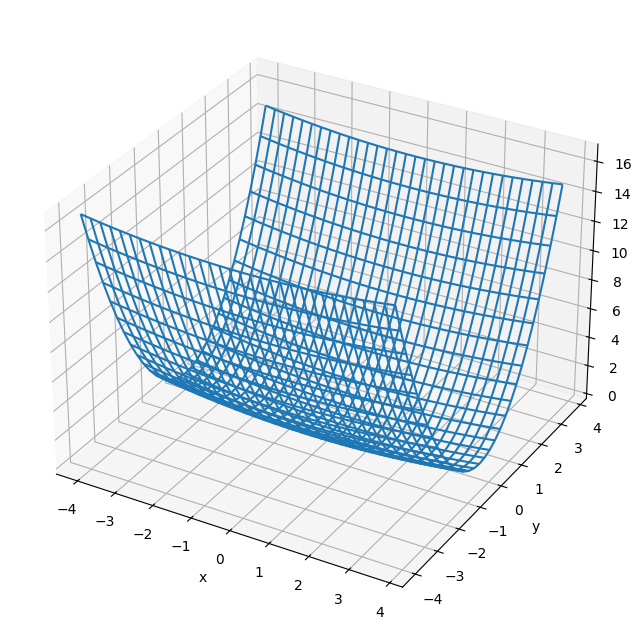

In [3]:
import numpy as np
import matplotlib.pylab as plt

# x0, x1 を -4 ～ +4 まで0.25刻み
x = np.arange(-4, 4, 0.25)
y = np.arange(-4, 4, 0.25)

# 格子点（X, Y）
X, Y = np.meshgrid(x, y)

# 格、格子点でのZ
Z = X**2 / 20.0 + Y**2

# ワイヤーフレーム図を作成
fig = plt.figure(figsize=(8, 8)) # 図の設定
ax = fig.add_subplot(projection='3d') # 3D用の設定
ax.plot_wireframe(X, Y, Z) # ワイヤーフレーム図
ax.set_xlabel('x') # x軸ラベル
ax.set_ylabel('y') # y軸ラベル
ax.set_zlabel('z') # z軸ラベル
plt.show()

#### 曲面の偏微分

##### 偏微分して勾配を計算

In [4]:
# cf.http://d.hatena.ne.jp/white_wheels/20100327/p3
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

# 偏微分（勾配を返す）
def numerical_gradient(f, X):
    h = 1e-4  # 0.0001
    
    # 要素の値が0の同じ形式のn行２列の行列
    grad1 = np.zeros_like(X)
        
    for idx1, x in enumerate(X):
        
        # 要素の値が0の同じ形式の２列のベクトル
        grad2 = np.zeros_like(x)
        
        for idx2 in range(x.size):
            tmp_val = x[idx2]
            
            x[idx2] = float(tmp_val) + h
            fxh1 = f(x)  # f(x+h)
            
            x[idx2] = tmp_val - h 
            fxh2 = f(x)  # f(x-h)
            
            grad2[idx2] = (fxh1 - fxh2) / (2*h)
            x[idx2] = tmp_val  # 値を元に戻す
        
        grad1[idx1] = grad2
        
    return grad1

# 偏微分対象の関数（曲面）
def function_3(x):
    return x[0]**2 / 20.0 + x[1]**2

# 曲面の格子点での勾配を計算
# 格子点をベクトル化して
_X = X.flatten()
_Y = Y.flatten()
# n行２列の全ペアにして（.Tは転置を意味）
koushiten = np.array([_X, _Y]).T
# 格子点での勾配を返す（.Tは転置を意味）
grad = numerical_gradient(function_3, koushiten).T

##### 結果の図示

###### 図示１

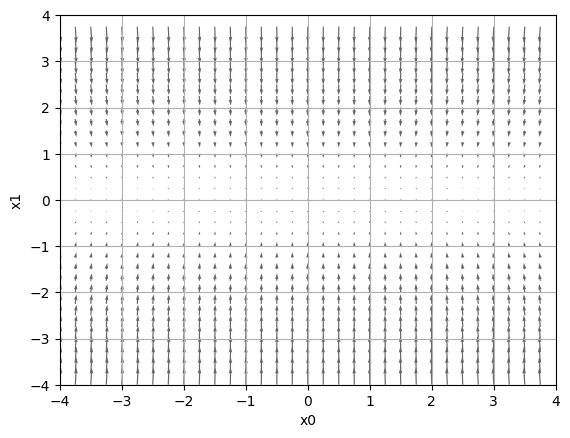

In [5]:
# 図示 
plt.figure()
# ベクトル場を表示
plt.quiver(_X, _Y, -grad[0], -grad[1],  angles="xy",color="#666666")
# 範囲
plt.xlim([-4, 4])
plt.ylim([-4, 4])
# 凡例
plt.xlabel('x0')
plt.ylabel('x1')

plt.grid()
plt.draw()
plt.show()

###### 図示２
等高線を足してみる。

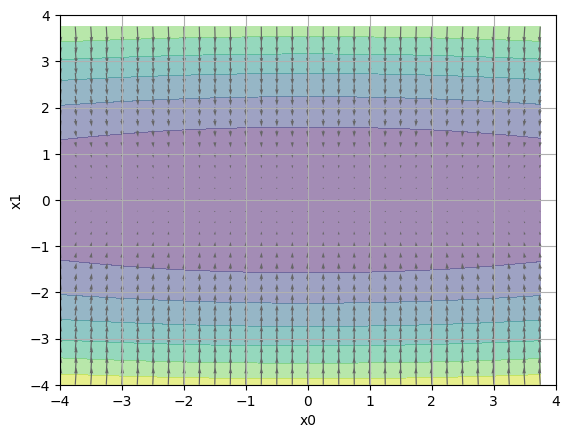

In [6]:
# 図示 
plt.figure()

# 等高線を表示 --------------------
plt.contourf(X, Y, Z, alpha=0.5)
# ---------------------------------

# ベクトル場を表示
plt.quiver(_X, _Y, -grad[0], -grad[1],  angles="xy",color="#666666")

# 範囲
plt.xlim([-4, 4])
plt.ylim([-4, 4])
# 凡例
plt.xlabel('x0')
plt.ylabel('x1')

plt.grid()
plt.draw()
plt.show()

###### 図示３
曲面に勾配を書いてみる。

/tmp/ipykernel_2026/4260932655.py:14: RuntimeWarning: invalid value encountered in divide
  ax.quiver(X, Y, Z, -dX/W, -dY/W, -W,


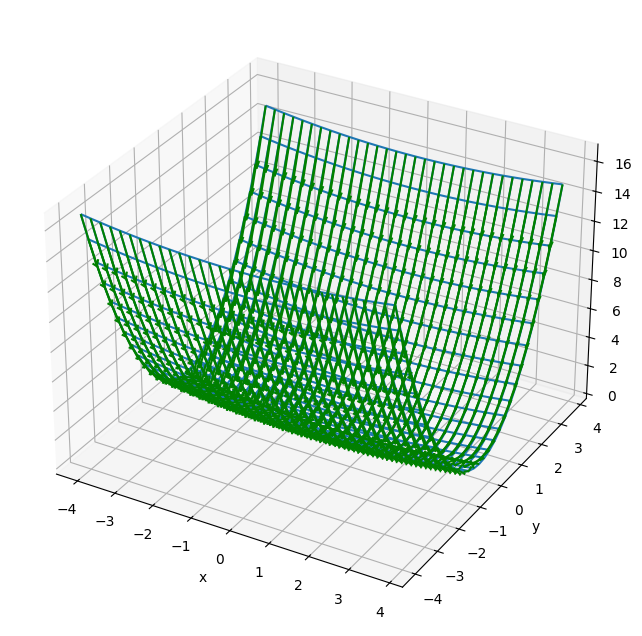

In [7]:
# 格子点のX、Y軸方向の勾配
dX = grad[0, :].reshape(X.shape)
dY = grad[1, :].reshape(Y.shape)

# Z軸方向の勾配を計算
W = np.sqrt(dX**2 + dY**2)

fig = plt.figure(figsize=(8, 8)) # 図の設定
ax = fig.add_subplot(projection='3d') # 3D用の設定

# 曲面
ax.plot_wireframe(X, Y, Z) # ワイヤーフレーム図
# 勾配
ax.quiver(X, Y, Z, -dX/W, -dY/W, -W, 
          color='green', pivot='tail', arrow_length_ratio=0.1, length=0.5, label='grad') 

ax.set_xlabel('x') # x軸ラベル
ax.set_ylabel('y') # y軸ラベル
ax.set_zlabel('z') # z軸ラベル
plt.show()

### 実装と検証

#### アルゴリズム説明

##### SGD
勾配が最も急な向きに勾配を下る手法
- 欠点の「最短距離でない、無駄に谷間を往復する。  
学習率が大きい場合は無駄な往復が目立つ。」が顕著。
- また、このケースでは他のアルゴリズムより学習率の初期値を  
大きく設定しており、他のケースでのチューニングが難しい。

##### Momentum
[SGD](#SGD)に慣性（加速・減速）の概念を加えた最適化手法｡
- 欠点の「加速しているため、極小値付近で止まり難い。」が顕著。
- 確かに物理法則に則った様な動きをしており[SGD](#SGD)より効率的。

##### AdaGrad
- 動いた量が増えたら更新が緩やかにする。
- このブレーキ機能は学習率の減衰によって実現されている。

##### Adam
[Momentum](#Momentum)＋[AdaGrad](#AdaGrad)的な。
- 慣性（加速・減速）とブレーキ機能を持ち合わせたアルゴリズム
- AdaGradの方が効率的に見えるが、場合によっては最適解を発見できる可能性がある。

#### イメージの曲面で勾配降下

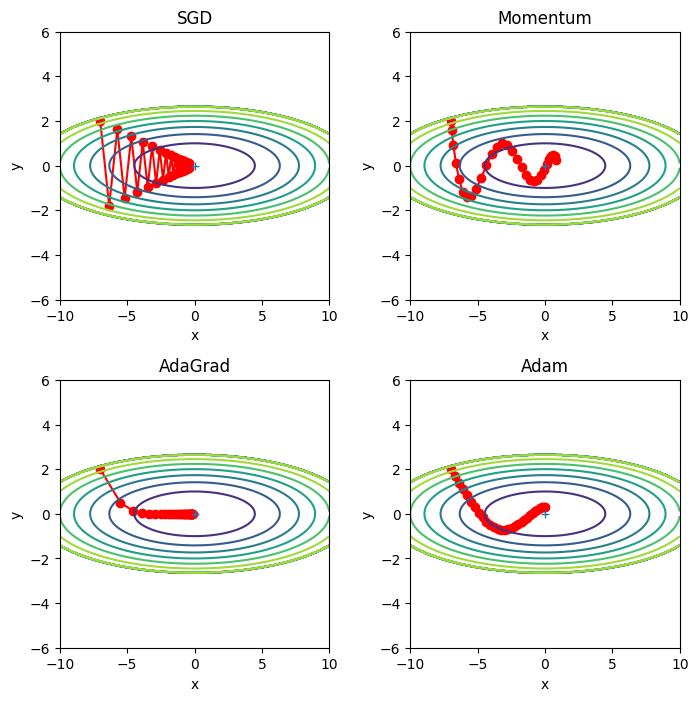

In [8]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from kasago.common.optimizer import *

# 曲面
def f(x, y):
    return x**2 / 20.0 + y**2

# 勾配（微分）
def df(x, y):
    return x / 10.0, 2.0*y

# 開始点
init_pos = (-7.0, 2.0)

# 現在地
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]

# 勾配
grads = {}
grads['x'], grads['y'] = 0, 0

# 勾配降下法のアルゴリズム
optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

# 表のサイズなど
plt.figure(figsize=(8, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# アルゴリズムを試す
idx = 1
for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    # 勾配降下
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        # 勾配
        grads['x'], grads['y'] = df(params['x'], params['y'])
        # 指定のアルゴリズムで（勾配降下
        optimizer.update(params, grads)

    # x, y を -10, -5 ～ 10, 5 まで0.01刻み
    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    # 格子点（X, Y）
    X, Y = np.meshgrid(x, y) 
    # 格、格子点でのZ
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-6, 6)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

#### 実際にMINST画像認識で勾配降下

===========iteration:0===========
SGD:2.2915565751256244
Momentum:2.302842296641607
AdaGrad:2.314846228658361
Adam:2.1979998594984176
===========iteration:100===========
SGD:1.2724277504910488
Momentum:0.35311114051554915
AdaGrad:0.19699947437940177
Adam:0.31650110271945675
===========iteration:200===========
SGD:0.8253732344081114
Momentum:0.3529519998081634
AdaGrad:0.17903403371839605
Adam:0.2859803336094825
===========iteration:300===========
SGD:0.5036754678103947
Momentum:0.24011278111130874
AdaGrad:0.05518334433619719
Adam:0.0967302553199018
===========iteration:400===========
SGD:0.33438862083013804
Momentum:0.09648775382691512
AdaGrad:0.0414339402199506
Adam:0.06461623880189363
===========iteration:500===========
SGD:0.5397015973480507
Momentum:0.2562022051900275
AdaGrad:0.1183322747023059
Adam:0.24264907668001218
===========iteration:600===========
SGD:0.27484637531119854
Momentum:0.09164986828176455
AdaGrad:0.04865320058279529
Adam:0.06684170995646074
===========iteration:700

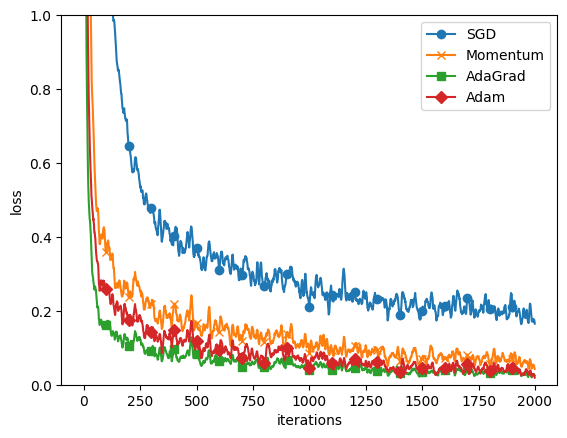

In [9]:
import os, sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from kasago.dataset.mnist import load_mnist
from kasago.common.util import smooth_curve
from kasago.common.multi_layer_net import MultiLayerNet
from kasago.common.optimizer import *

# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# パイパーパラメタ
train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000
# アルゴリズム設定
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

# 1:実験の設定==========

# モデルのリスト
networks = {}

# 損失の履歴
train_loss = {}

# アルゴリズム毎に異なるモデルを生成
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784,                        # 入力は28*28
        hidden_size_list=[100, 100, 100, 100], # 中間層は100
        output_size=10)                        # 出力は10クラス分類
    train_loss[key] = []                       # 損失の履歴

# 2:訓練の開始==========
# max_iterations回繰り返す。
for i in range(max_iterations):
    # train_sizeからbatch_size抜くインデックス
    batch_mask = np.random.choice(train_size, batch_size)
    # インデックスでXとYのバッチの訓練データを抜く
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # モデル毎に（アルゴリズムを替え）繰り返す。
    for key in optimizers.keys():
        # 勾配を求めて
        grads = networks[key].gradient(x_batch, t_batch)
        # アルゴリズムで更新
        optimizers[key].update(networks[key].params, grads)
        # 更新後の損失を求めて
        loss = networks[key].loss(x_batch, t_batch)
        # 損失の履歴に格納
        train_loss[key].append(loss)
        
    # 100回毎にアルゴリズム毎の損失を表示
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 3.損失の履歴をグラフ描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## アクティベーション分布
- アクティベーションとは活性化関数の出力を言う。
- このアクティベーションの分布が、
  - 活性化関数の勾配０近辺に偏ると勾配消失が起きる。
  - また、偏りがあると、表現力の制限問題が起きる。
- これを回避するようアクティベーション分布をバラけさせる。

### 重み初期値
アクティベーション分布をバラけさせるように重みを初期値する方法。

#### ５層のアフィン変換でアクティベーション分布確認

##### ５層のアフィン変換の関数定義

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 活性化関数
## sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
## tanh
def tanh(x):
    return np.tanh(x)
## ReLU
def ReLU(x):
    return np.maximum(0, x)

def activation_histogram(hidden_layer_size, activation_func, x, w, hight=7000, width=1):
    # ここにアクティベーションの結果を格納する
    activations = {}  

    # 層の数だけアクティベーション
    for i in range(hidden_layer_size):
        # 前層の出力を取り出す。
        if i != 0:
            x = activations[i-1]
        # 全結合
        a = np.dot(x, w)
        # 活性化関数
        z = activation_func(a)
        # 出力の保存
        activations[i] = z

    # ヒストグラムを描画
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0: plt.yticks([], [])
        plt.ylim(0, hight)
        plt.xlim(0, width)
        plt.hist(a.flatten(), 30, range=(0,1))
        
    # ヒストグラムを表示
    plt.show()

##### 実行準備

In [11]:
hidden_layer_size = 5 # 隠れ層の数
node_num = 100        # 層のノード数

# 1000行node_num列の正規分布の乱数
input_data = np.random.randn(1000, node_num)  

##### sigmoidの場合

###### 重みの標準偏差１
０・１に偏る。表現力問題と勾配消失が起きる。

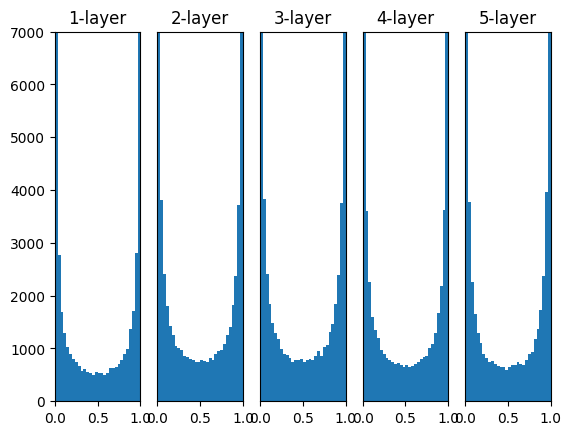

In [12]:
# 活性化関数
activation_func = sigmoid
# 重みの初期値
w = np.random.randn(node_num, node_num) * 1

activation_histogram(hidden_layer_size, activation_func, input_data, w)

###### 重みの標準偏差0.01
0.5に偏る。勾配消失は防いだが表現力問題が残る。

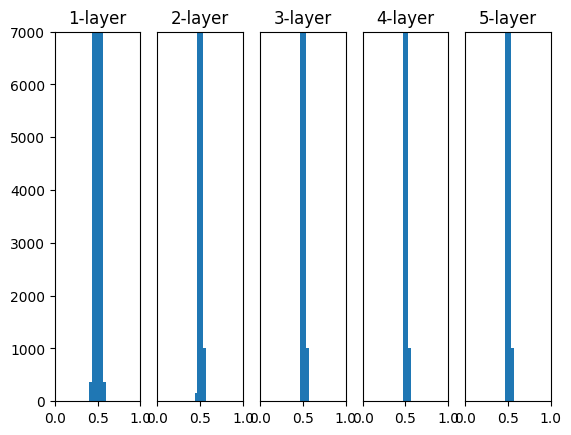

In [13]:
# 活性化関数
activation_func = sigmoid
# 重みの初期値
w = np.random.randn(node_num, node_num) * 0.01

activation_histogram(hidden_layer_size, activation_func, input_data, w)

###### 重みの標準偏差 Xavier
- 広がりを持った分布で勾配消失や表現力問題が解消する。
- 出力層に近づくにつれて若干、歪な分布になる。

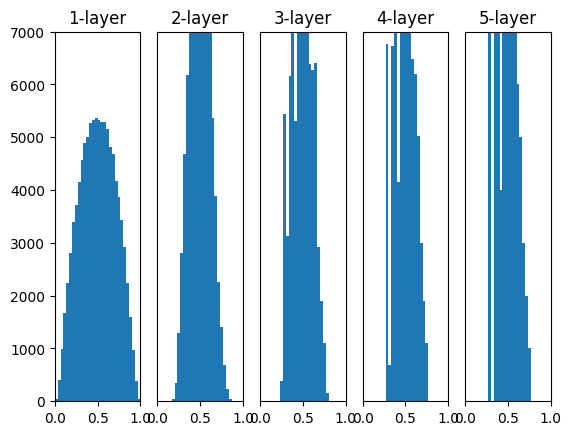

In [14]:
# 活性化関数
activation_func = sigmoid
# 重みの初期値
w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)

activation_histogram(hidden_layer_size, activation_func, input_data, w)

##### tanhの場合

###### 重みの標準偏差１

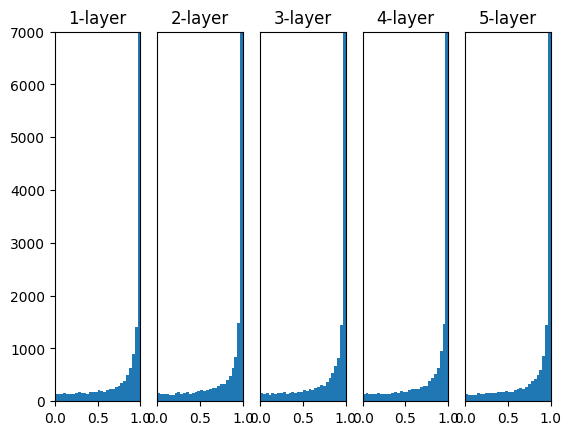

In [15]:
# 活性化関数
activation_func = tanh
# 重みの初期値
w = np.random.randn(node_num, node_num) * 1

activation_histogram(hidden_layer_size, activation_func, input_data, w)

###### 重みの標準偏差0.01

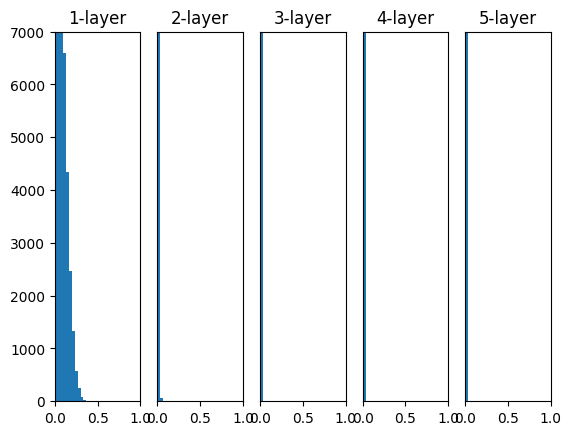

In [16]:
# 活性化関数
activation_func = tanh
# 重みの初期値
w = np.random.randn(node_num, node_num) * 0.01

activation_histogram(hidden_layer_size, activation_func, input_data, w)

###### 重みの標準偏差 Xavier

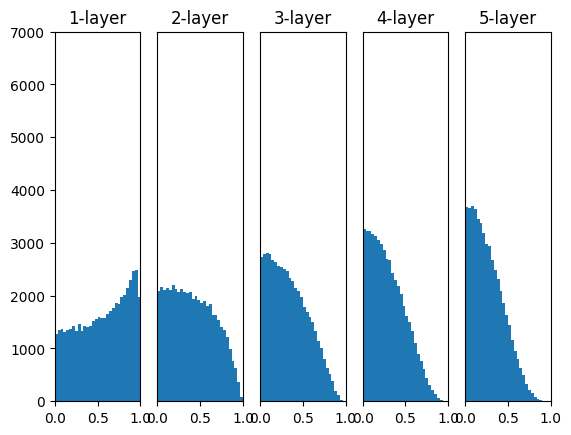

In [17]:
# 活性化関数
activation_func = tanh
# 重みの初期値
w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)

activation_histogram(hidden_layer_size, activation_func, input_data, w)

##### ReLUの場合

###### 重みの標準偏差１
- マイナスは全て０なので偏り、深くなると更に偏る。
- 表現力問題と勾配消失が起きる。

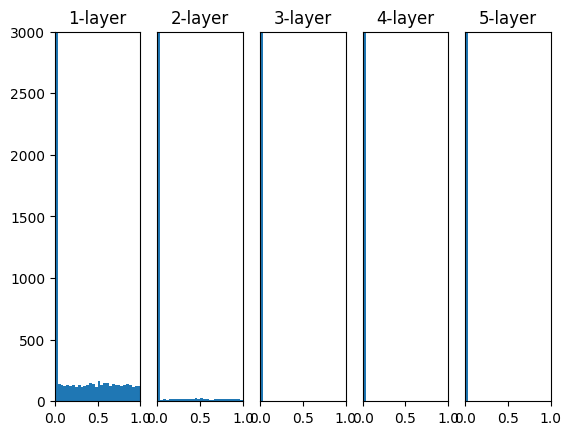

In [18]:
# 活性化関数
activation_func = ReLU
# 重みの初期値
w = np.random.randn(node_num, node_num) * 1

activation_histogram(hidden_layer_size, activation_func, input_data, w, 3000)

###### 重みの標準偏差0.01
標準偏差１より問題は若干緩和するが解決はしていない。

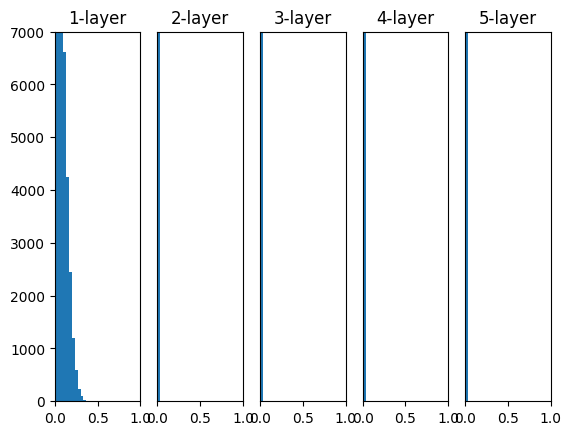

In [19]:
# 活性化関数
activation_func = ReLU
# 重みの初期値
w = np.random.randn(node_num, node_num) * 0.01

activation_histogram(hidden_layer_size, activation_func, input_data, w)

###### 重みの標準偏差 Xavier
偏りが解消されつつある。

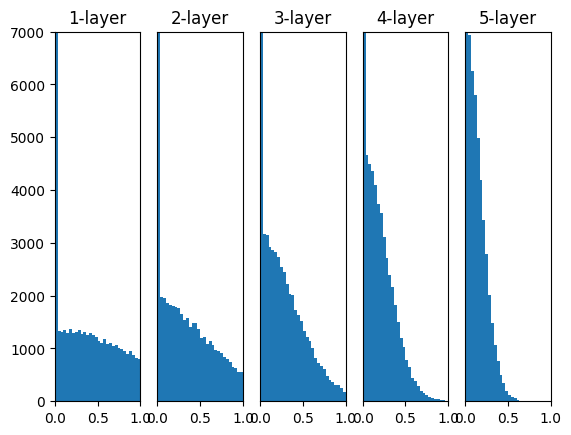

In [20]:
# 活性化関数
activation_func = ReLU
# 重みの初期値
w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)

activation_histogram(hidden_layer_size, activation_func, input_data, w)

###### 重みの標準偏差 He
偏りが解消された。

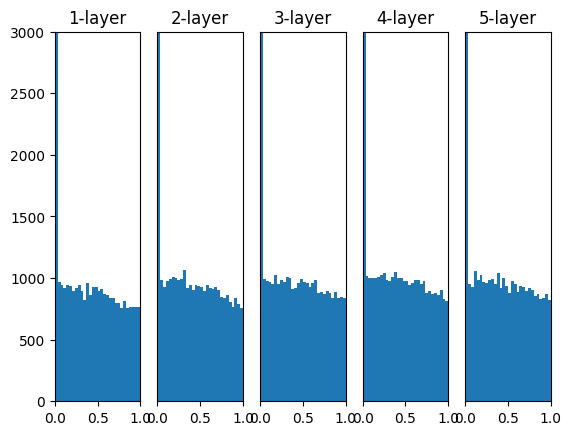

In [21]:
# 活性化関数
activation_func = ReLU
# 重みの初期値
w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

activation_histogram(hidden_layer_size, activation_func, input_data, w, 3000)

#### 実際にMINST画像認識で３つの重み初期値をテスト
活性化関数はReLUなので、
- Heの初期化が一番上手く学習できる。
- 次いで、Xavierで上手く学習できる。
- 標準偏差0.01では勾配消失で学習できない。

===========iteration:0===========
std=0.01:2.3025230696865773
Xavier:2.3048491096514807
He:2.405643701495885
===========iteration:100===========
std=0.01:2.301941663216496
Xavier:2.26638585523491
He:1.803924822442646
===========iteration:200===========
std=0.01:2.3029287985858518
Xavier:2.162322838449479
He:0.9396240061788437
===========iteration:300===========
std=0.01:2.301439393387568
Xavier:1.9159532051832875
He:0.6735371068401149
===========iteration:400===========
std=0.01:2.3000930809122866
Xavier:1.3532056143835214
He:0.37192531519622674
===========iteration:500===========
std=0.01:2.3030546903572353
Xavier:0.9717750432179577
He:0.5072876557729447
===========iteration:600===========
std=0.01:2.3041868328592017
Xavier:0.7080791540159144
He:0.325372416805582
===========iteration:700===========
std=0.01:2.3024188192501938
Xavier:0.652896168810553
He:0.46262811824992234
===========iteration:800===========
std=0.01:2.301290174497967
Xavier:0.4669428136050775
He:0.2692813527075903
==

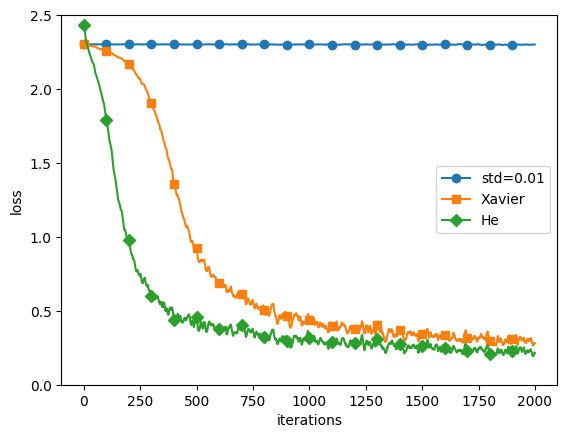

In [22]:
import os, sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from kasago.dataset.mnist import load_mnist
from kasago.common.util import smooth_curve
from kasago.common.multi_layer_net import MultiLayerNet
from kasago.common.optimizer import SGD

# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# パイパーパラメタ
train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000
# 重み初期化方法の設定
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

# 1:実験の設定==========

# モデルのリスト
networks = {}

# 損失の履歴
train_loss = {}

# 重み初期化方法の異なるモデルの生成
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(
        input_size=784,                        # 入力は28*28
        hidden_size_list=[100, 100, 100, 100], # 中間層は100
        output_size=10,                        # 出力は10クラス分類
        weight_init_std=weight_type)           # 重み初期化方法の設定
    train_loss[key] = []                       # 損失の履歴

# 2:訓練の開始==========
# max_iterations回繰り返す。
for i in range(max_iterations):
    # train_sizeからbatch_size抜くインデックス
    batch_mask = np.random.choice(train_size, batch_size)
    # インデックスでXとYのバッチの訓練データを抜く
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 重み初期化方法の異なるモデル毎に繰り返す。
    for key in weight_init_types.keys():
        # 勾配を求めて
        grads = networks[key].gradient(x_batch, t_batch)
        # アルゴリズムで更新
        optimizer.update(networks[key].params, grads)
        # 更新後の損失を求めて
        loss = networks[key].loss(x_batch, t_batch)
        # 損失の履歴に格納
        train_loss[key].append(loss)
        
    # 100回毎にアルゴリズム毎の損失を表示
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))
            
# 3.損失の履歴をグラフ描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

### [バッチ正規化_BatchNormalization](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E3%81%AE%E3%83%86%E3%82%AF%E3%83%8B%E3%83%83%E3%82%AF#t3c6ab88)
- [重み初期値](#重み初期値)ではなく、各層で強制的にアクティベーションう分布を調整する。
- MultiLayerNetExtendの実装では、全ての全結合と活性化関数の間にバッチ正規化層が挿入されるもよう。

In [23]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from kasago.common.multi_layer_net_extend import MultiLayerNetExtend
from kasago.common.optimizer import SGD, Adam

def __train(weight_init_std, x_train, y_train):
    
    # 1:実験の設定（重み初期化方法の設定）==========

    # ハイパーパラメタ
    train_size = x_train.shape[0]
    batch_size = 100
    max_epochs = 20
    iter_per_epoch = max(train_size / batch_size, 1)
    learning_rate = 0.01
    optimizer = SGD(lr=learning_rate)

    # バッチ正規化の有無の異なるモデルの生成
    ## バッチ正規化ナシ
    network1 = MultiLayerNetExtend(
        input_size=784,
        hidden_size_list=[100, 100, 100, 100, 100],
        output_size=10,
        weight_init_std=weight_init_std)
    
    ## バッチ正規化アリ
    network2 = MultiLayerNetExtend(
        input_size=784,
        hidden_size_list=[100, 100, 100, 100, 100],
        output_size=10, 
        weight_init_std=weight_init_std,
        use_batchnorm=True)
    
    # acc履歴
    train_acc_list1 = []
    train_acc_list2 = []
    
    # 2:訓練の開始==========
    epoch_cnt = 0
    # max_iterationsじゃなくて1000000000回繰り返す。
    for i in range(1000000000):
        # train_sizeからbatch_size抜くインデックス
        batch_mask = np.random.choice(train_size, batch_size)
        # インデックスでXとYのバッチの訓練データを抜く
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        # モデル毎に繰り返す。
        for _network in (network1, network2):
            # 勾配を求めて
            grads = _network.gradient(x_batch, t_batch)
            # アルゴリズムで更新
            optimizer.update(_network.params, grads)
            
        # エポック毎に
        if i % iter_per_epoch == 0:
            # ACCを求めて
            train_acc1 = network1.accuracy(x_train, t_train)
            train_acc2 = network2.accuracy(x_train, t_train)
            # ACC履歴に格納
            train_acc_list1.append(train_acc1)
            train_acc_list2.append(train_acc2)
            # ACCログ表示
            # print("epoch:" + str(epoch_cnt)  + ", train acc1-2 : " + str(train_acc1) + " - " + str(train_acc2))
            # エポック超えたら完了
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list1, train_acc_list2

============== 1/16 ==============
============== 2/16 ==============


/mnt/d/git/Dev/OpenTouryoProject/DX/DxCommon/Notebook/Jupyter/path/kasago/common/multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/mnt/d/git/Dev/OpenTouryoProject/DX/DxCommon/Notebook/Jupyter/path/kasago/common/multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in scalar multiply
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/mnt/d/git/Dev/OpenTouryoProject/DX/DxCommon/Notebook/Jupyter/path/kasago/common/functions.py:32: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策


============== 3/16 ==============
============== 4/16 ==============
============== 5/16 ==============
============== 6/16 ==============
============== 7/16 ==============
============== 8/16 ==============
============== 9/16 ==============
============== 10/16 ==============
============== 11/16 ==============
============== 12/16 ==============
============== 13/16 ==============
============== 14/16 ==============
============== 15/16 ==============
============== 16/16 ==============


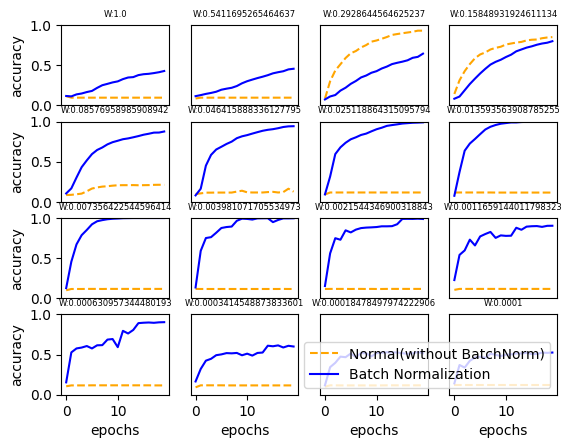

In [24]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from kasago.dataset.mnist import load_mnist

# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

# 重みの初期値のリスト（0-0.0001の対数スケールが等間隔の数値16個）
weight_scale_list = np.logspace(0, -4, num=16)

for i, w in enumerate(weight_scale_list):
    print("============== " + str(i+1) + "/16" + " ==============")

    # 1:実験の設定（重み初期化方法の設定）==========
    # 2:訓練の開始==========
    train_acc_list1, train_acc_list2 = __train(w, x_train, t_train)    
    
    # 3.グラフの描画==========
    # subplot
    plt.subplot(4, 4, i+1)
    # タイトルに重みの初期値
    plt.title("W:" + str(w), fontsize=6)
    
    # x軸はエポックの意
    x = np.arange(len(train_acc_list1))

    if i == 15:
        # 凡例
        plt.plot(x, train_acc_list1, color='orange', linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
        plt.plot(x, train_acc_list2, color='blue',                     label='Batch Normalization', markevery=2)
        
    else:
        # subplot
        plt.plot(x, train_acc_list1, color='orange', linestyle="--", markevery=2)
        plt.plot(x, train_acc_list2, color='blue',                   markevery=2)

    plt.ylim(0, 1.0)
    
    # 最左部にaccuracy、最下部にepochs
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
        
plt.legend(loc='lower right')    
plt.show()

## 過学習の対策＝汎化性能の向上

### 過学習を荷重減衰による正則化で対策
[正則化回帰分析](ScikitLearnTraining2.ipynb)のような正則化項を使った方法らしい。

nw1 epoch:0, train acc:0.03, test acc:0.095
nw2 epoch:0, train acc:0.09333333333333334, test acc:0.1075
nw1 epoch:10, train acc:0.32666666666666666, test acc:0.2485
nw2 epoch:10, train acc:0.3466666666666667, test acc:0.2882
nw1 epoch:20, train acc:0.6, test acc:0.4328
nw2 epoch:20, train acc:0.44333333333333336, test acc:0.3852
nw1 epoch:30, train acc:0.6733333333333333, test acc:0.5107
nw2 epoch:30, train acc:0.55, test acc:0.4464
nw1 epoch:40, train acc:0.78, test acc:0.5707
nw2 epoch:40, train acc:0.7, test acc:0.5384
nw1 epoch:50, train acc:0.8466666666666667, test acc:0.6162
nw2 epoch:50, train acc:0.7466666666666667, test acc:0.5862
nw1 epoch:60, train acc:0.88, test acc:0.6294
nw2 epoch:60, train acc:0.81, test acc:0.6323
nw1 epoch:70, train acc:0.91, test acc:0.6583
nw2 epoch:70, train acc:0.8233333333333334, test acc:0.6395
nw1 epoch:80, train acc:0.9366666666666666, test acc:0.6862
nw2 epoch:80, train acc:0.8666666666666667, test acc:0.6809
nw1 epoch:90, train acc:0.95666666

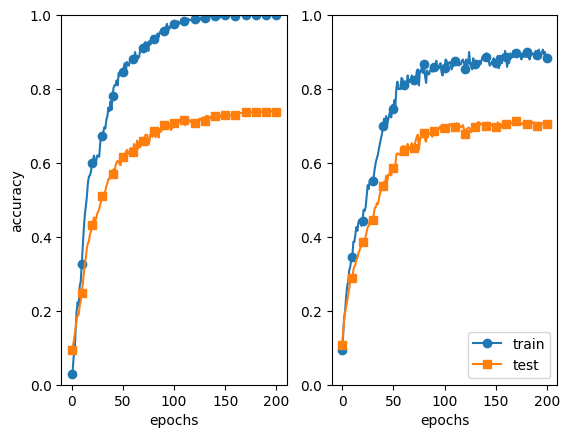

In [25]:
import os, sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from kasago.dataset.mnist import load_mnist
from kasago.common.multi_layer_net import MultiLayerNet
from kasago.common.optimizer import SGD

# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# パイパーパラメタ
train_size = x_train.shape[0]
batch_size = 100
max_epochs = 201
iter_per_epoch = max(train_size / batch_size, 1)
learning_rate = 0.01
optimizer = SGD(lr=learning_rate)

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

# 1:実験の設定（重み初期化方法の設定）==========

# モデルの生成
network1 = MultiLayerNet(
    input_size=784,
    hidden_size_list=[100, 100, 100, 100, 100, 100],
    output_size=10)

network2 = MultiLayerNet(
    input_size=784,
    hidden_size_list=[100, 100, 100, 100, 100, 100],
    output_size=10,
    weight_decay_lambda=weight_decay_lambda)

# ACCの履歴
train_acc_list1 = []
test_acc_list1 = []
train_acc_list2 = []
test_acc_list2 = []

# 2:訓練の開始==========
epoch_cnt = 0
# max_iterationsじゃなくて1000000000回繰り返す。
for i in range(1000000000):
    # train_sizeからbatch_size抜くインデックス
    batch_mask = np.random.choice(train_size, batch_size)
    # インデックスでXとYのバッチの訓練データを抜く
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配を求めて
    grads1 = network1.gradient(x_batch, t_batch)
    grads2 = network2.gradient(x_batch, t_batch)
    # 勾配を求めて
    optimizer.update(network1.params, grads1)
    optimizer.update(network2.params, grads2)
    
    # エポック毎に
    if i % iter_per_epoch == 0:
        # ACCを求めて
        train_acc1 = network1.accuracy(x_train, t_train)
        test_acc1 = network1.accuracy(x_test, t_test)
        train_acc2 = network2.accuracy(x_train, t_train)
        test_acc2 = network2.accuracy(x_test, t_test)
        # ACC履歴に格納
        train_acc_list1.append(train_acc1)
        test_acc_list1.append(test_acc1)
        train_acc_list2.append(train_acc2)
        test_acc_list2.append(test_acc2)
        # ACCログ表示
        if (epoch_cnt % 10) == 0:
            print("nw1 epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc1) + ", test acc:" + str(test_acc1))
            print("nw2 epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc2) + ", test acc:" + str(test_acc2))
        # エポック超えたら完了
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)

# subplot
plt.subplot(1, 2, 1)
plt.plot(x, train_acc_list1, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list1, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)

plt.subplot(1, 2, 2)
plt.plot(x, train_acc_list2, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list2, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
#plt.ylabel("accuracy")
plt.ylim(0, 1.0)

plt.legend(loc='lower right')
plt.show()

### 過学習を[ドロップアウト](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E3%81%AE%E3%83%86%E3%82%AF%E3%83%8B%E3%83%83%E3%82%AF#hf3c7a28)で対策
MultiLayerNetExtendの実装では、全ての活性化関数の後ろにドロップアウト層が挿入されるもよう。

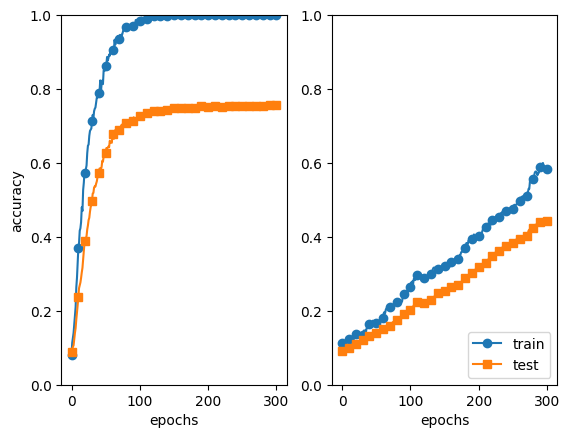

In [26]:
import os, sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from kasago.dataset.mnist import load_mnist
from kasago.common.multi_layer_net_extend import MultiLayerNetExtend
from kasago.common.trainer import Trainer

# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# パイパーパラメタ
# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

# 1:実験の設定==========
network1 = MultiLayerNetExtend(
    input_size=784,
    hidden_size_list=[100, 100, 100, 100, 100, 100],
    output_size=10)

network2 = MultiLayerNetExtend(
    input_size=784,
    hidden_size_list=[100, 100, 100, 100, 100, 100],
    output_size=10,
    use_dropout=use_dropout,
    dropout_ration=dropout_ratio)

# なにやらTrainerなるクラスが使えるもよう。
trainer1 = Trainer(network1, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)

trainer2 = Trainer(network2, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)

# 2:訓練の開始==========
with SuppressOutput():
    trainer1.train()
    trainer2.train()

train_acc_list1, test_acc_list1 = trainer1.train_acc_list, trainer1.test_acc_list
train_acc_list2, test_acc_list2 = trainer2.train_acc_list, trainer2.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list1))

# subplot
plt.subplot(1, 2, 1)
plt.plot(x, train_acc_list1, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list1, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.subplot(1, 2, 2)
plt.plot(x, train_acc_list2, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list2, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
#plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## ハイパーパラメタのランダム・サーチ
[機械学習の所で出てきたグリッドサーチ](ScikitLearnTraining5.ipynb)ならぬ、ランダムサーチ

In [28]:
from kasago.common.trainer import Trainer

def __train(lr, weight_decay, epocs=50):
    
    # 1:実験の設定==========
    network = MultiLayerNet(
        input_size=784,
        hidden_size_list=[100, 100, 100, 100, 100, 100],
        output_size=10, weight_decay_lambda=weight_decay)
    
    # なにやらTrainerなるクラスが使えるもよう。
    # 検証データとは言うモノのIF上ではテストデータに指定する。
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    
    # 2:訓練の開始==========
    trainer.train()
    
    return trainer.test_acc_list, trainer.train_acc_list

=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.81) | lr:0.009299977951844476, weight decay:1.2416602914783506e-08
Best-2(val acc:0.8) | lr:0.007312242882641339, weight decay:6.042204124448919e-08
Best-3(val acc:0.76) | lr:0.00569741804578343, weight decay:4.374351774684304e-07
Best-4(val acc:0.75) | lr:0.008374885640858469, weight decay:4.5365285644823324e-08
Best-5(val acc:0.71) | lr:0.004804658104129035, weight decay:5.556748529482441e-06
Best-6(val acc:0.71) | lr:0.006870893106603666, weight decay:3.93370795043057e-05
Best-7(val acc:0.54) | lr:0.004579572671030165, weight decay:2.2312662420173317e-07
Best-8(val acc:0.5) | lr:0.004337566404858565, weight decay:5.56696472932847e-08
Best-9(val acc:0.44) | lr:0.0026150256294031546, weight decay:2.6625963105124377e-06
Best-10(val acc:0.43) | lr:0.002507524873810396, weight decay:7.09211324291461e-08
Best-11(val acc:0.41) | lr:0.0024579528457480105, weight decay:2.126820136944299e-06
Best-12(val acc:0.41) | l

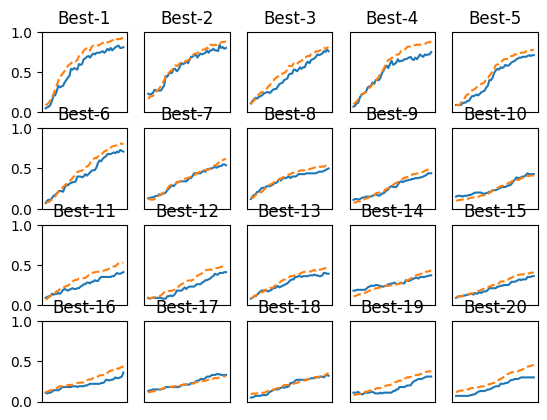

In [30]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from kasago.dataset.mnist import load_mnist
from kasago.common.multi_layer_net import MultiLayerNet
from kasago.common.util import shuffle_dataset

# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

# ハイパーパラメータのランダム探索======================================
results_val = {}
results_train = {}
optimization_trial = 100

# optimization_trial回繰り返す。nann
for _ in range(optimization_trial):
    # ハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    # 1:実験の設定（探索するハイパーパラメータを設定）==========
    # 2:訓練の開始==========
    val_acc_list, train_acc_list = __train(lr, weight_decay)
    # ACC履歴に格納
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list
    # ACCログ表示
    # print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20 # 上位20件表示
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num)) # 切り捨て

i = 0
for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    # 降順、lambdaは何をキーにsortするかで、keyに対応するACC履歴の末尾の値でソート
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    # subplot
    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    
    i += 1
    if i >= graph_draw_num:
        break

plt.show()